# Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
from pydub import AudioSegment
import io
import librosa
import soundfile as sf

C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
# https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
'''train dataset'''
df_val_train = pd.read_csv("sample_archive/cv-valid-train.csv")
df_val_train['filename'] = 'sample_archive' + '/' + df_val_train['filename'].astype(str)
df_val_train = df_val_train[['filename', 'text']]
df_val_train.head()

In [ ]:
df_val_train['filename'][0]

In [3]:
SPEECH = os.path.join('sample_archive', 'cv-valid-dev', 'sample-000000.mp3') #path to the .mp3 audio files
NOT_SPEECH = os.path.join('sample_archive', 'cv-invalid', 'sample-000000.mp3')


building data loading function

In [4]:
def load_wav_16k_mono(filename):
    # Load MP3 file
    audio, sample_rate = librosa.load(filename, sr=None, mono=True)
    
    # Resample to 16kHz
    wav = tf.convert_to_tensor(audio, dtype=tf.float32)
    wav = tf.squeeze(wav)
    sample_rate = tf.cast(sample_rate, dtype=tf.float32)
    # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) 
    return wav

In [5]:
audio, sample_rate = librosa.load(SPEECH, sr=None, mono=True)
audio

array([ 0.0000000e+00,  6.0267407e-17,  6.6503389e-17, ...,
       -2.2499556e-07, -1.1590049e-07,  1.5916493e-07], dtype=float32)

In [6]:
sample_rate = tf.cast(sample_rate, dtype=tf.float32)
sample_rate


<tf.Tensor: shape=(), dtype=float32, numpy=48000.0>

In [7]:
wave = load_wav_16k_mono(SPEECH)
nwave = load_wav_16k_mono(NOT_SPEECH)

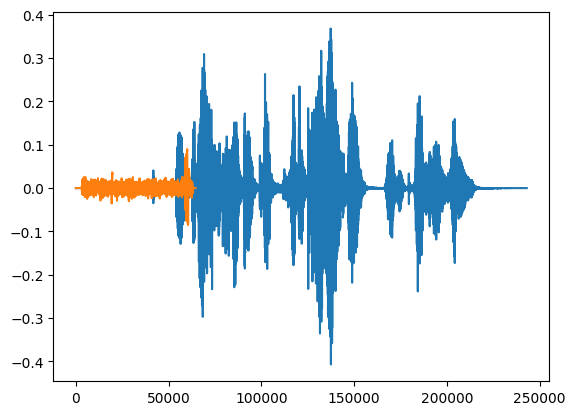

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [9]:
VAL = os.path.join('sample_archive', 'cv-valid-dev')
INVAL = os.path.join('sample_archive', 'cv-invalid')

In [10]:
val = tf.data.Dataset.list_files(VAL+'\*.mp3')
inval = tf.data.Dataset.list_files(INVAL+'\*.mp3')

In [11]:
valid = tf.data.Dataset.zip(val, tf.data.Dataset.from_tensor_slices(tf.ones(len(val))))
invalid = tf.data.Dataset.zip(inval, tf.data.Dataset.from_tensor_slices(tf.zeros(len(inval))))
data = valid.concatenate(invalid)
# len(valid)
# len(invalid)
# len(data)

training model on valid dataset

In [12]:
lengths = []
for file in os.listdir(os.path.join('sample_archive', 'cv-valid-dev')):
    tensor_wave = load_wav_16k_mono(os.path.join('sample_archive', 'cv-valid-dev', file))
    lengths.append(len(tensor_wave))
# lengths

In [13]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=227520>

In [14]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=93312>

In [15]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=554112>

In [16]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:98000]
    zero_padding = tf.zeros([98000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [17]:
filepath, label = valid.shuffle(buffer_size=100).as_numpy_iterator().next()
label

1.0

In [18]:
filepath

b'sample_archive\\cv-valid-dev\\sample-000010.mp3'

In [19]:
spectrogram, label = preprocess(filepath, label)

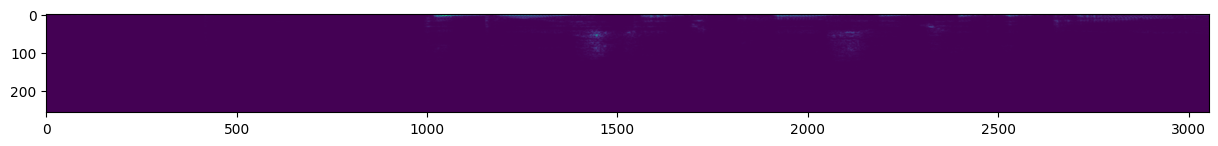

In [20]:
plt.figure(figsize=(15,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

data is preprocessed
goal: interprets correclty even in its blabbered voice
i have to train on csv texts of some good voice and bad voice

In [21]:
# data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=100)
data = data.batch(25)               # https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
# data = data.prefetch(12)
len(data)

4

In [22]:
train = data.take(3)
test = data.skip(3).take(1)

In [23]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(25,)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
# model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 487, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1971376)           0         
                                                                 
 dense (Dense)               (None, 20)                39427540  
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 39430041 (150.41 MB)
Trainable params: 39430041 (150.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


ValueError: in user code:

    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\shree\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None
